In [1]:
import os
import sys
import json
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
BASE_DIR = '../mnt/inputs/origin'
TRN_BASE_DIR = '../mnt/inputs/features/train'
TST_BASE_DIR = '../mnt/inputs/features/test'
# BASE_DIR = '../mnt/inputs/features/test'

In [3]:
trn_df = pd.read_pickle(f'{BASE_DIR}/train.pkl.gz')
trn_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
tst_df = pd.read_csv(f'{BASE_DIR}/test.csv')
tst_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [75]:
sub_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

In [36]:
specs_df = pd.read_csv(f'{BASE_DIR}/specs.csv')

In [5]:
label_df = pd.read_csv('../mnt/inputs/origin/train_labels.csv')
label_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [37]:
specs_df = specs_df.merge(tst_df.drop_duplicates(['event_id', 'event_code'])[['event_id', 'event_code', 'world']], on='event_id', how='left')

In [39]:
specs_df.query('event_code == 4010').sort_values('world')

,event_id,info,args,event_code,world
112,abc5811c,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,CRYSTALCAVES
195,0086365d,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,CRYSTALCAVES
257,fd20ea40,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,CRYSTALCAVES
311,f93fc684,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,CRYSTALCAVES
173,8d84fa81,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,MAGMAPEAK
197,87d743c1,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,MAGMAPEAK
372,5be391b5,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,MAGMAPEAK
380,7040c096,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,MAGMAPEAK
11,4b5efe37,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,TREETOPCITY
190,65abac75,This event occurs when the player clicks to st...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4010.0,TREETOPCITY


In [187]:
imp_df =  pd.read_csv('../mnt/importances/e025.csv')

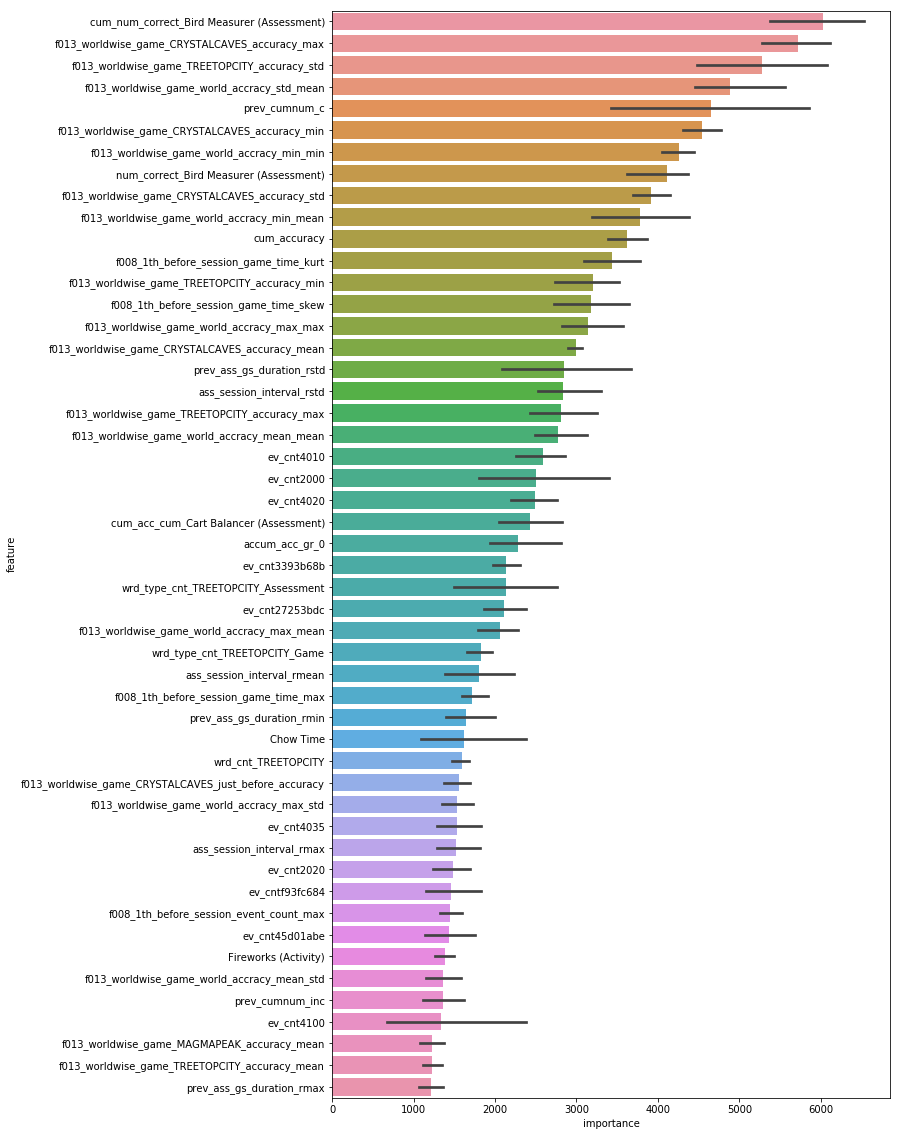

In [188]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().feature.head(50))

In [195]:
imp_df =  pd.read_csv('../mnt/importances/e025.csv')

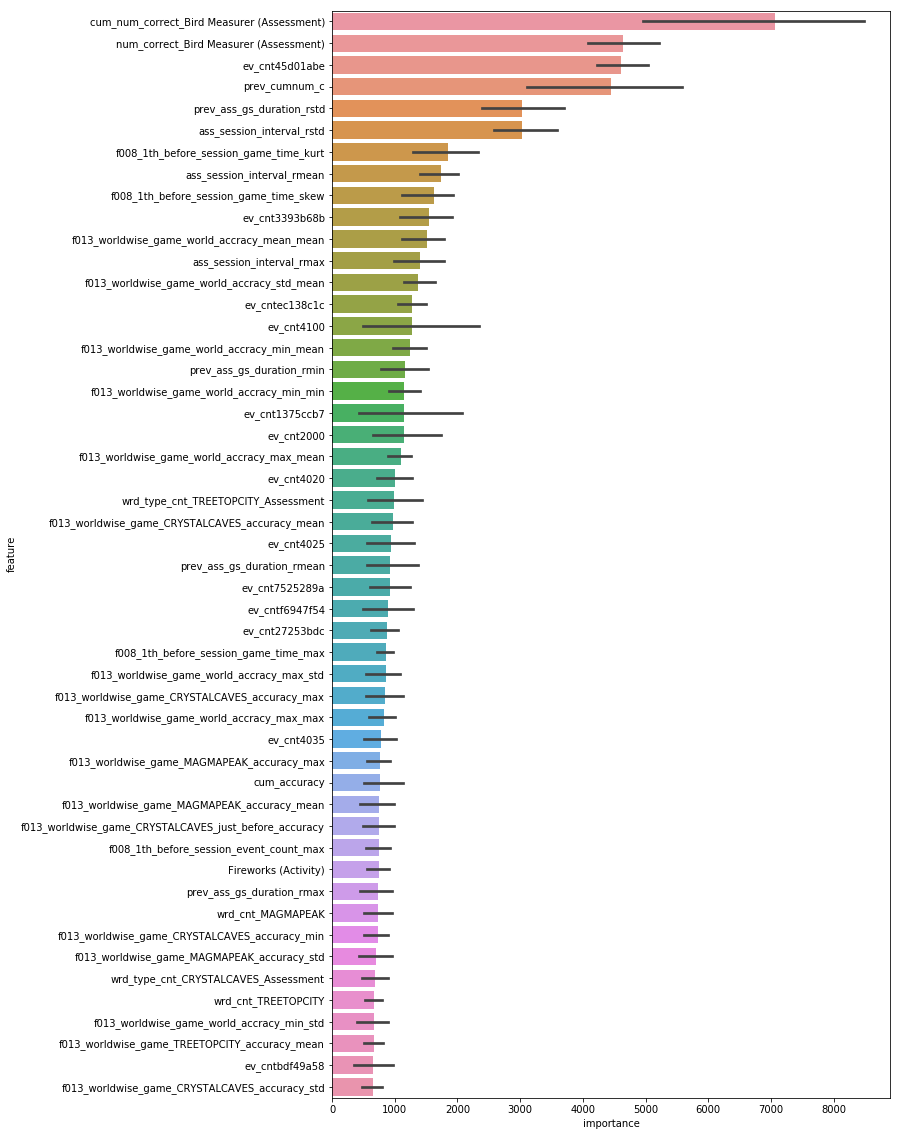

In [196]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().feature.head(50))

## adv の importance 確認してみる

In [197]:
imp_df =  pd.read_csv('../mnt/importances/e025.csv')

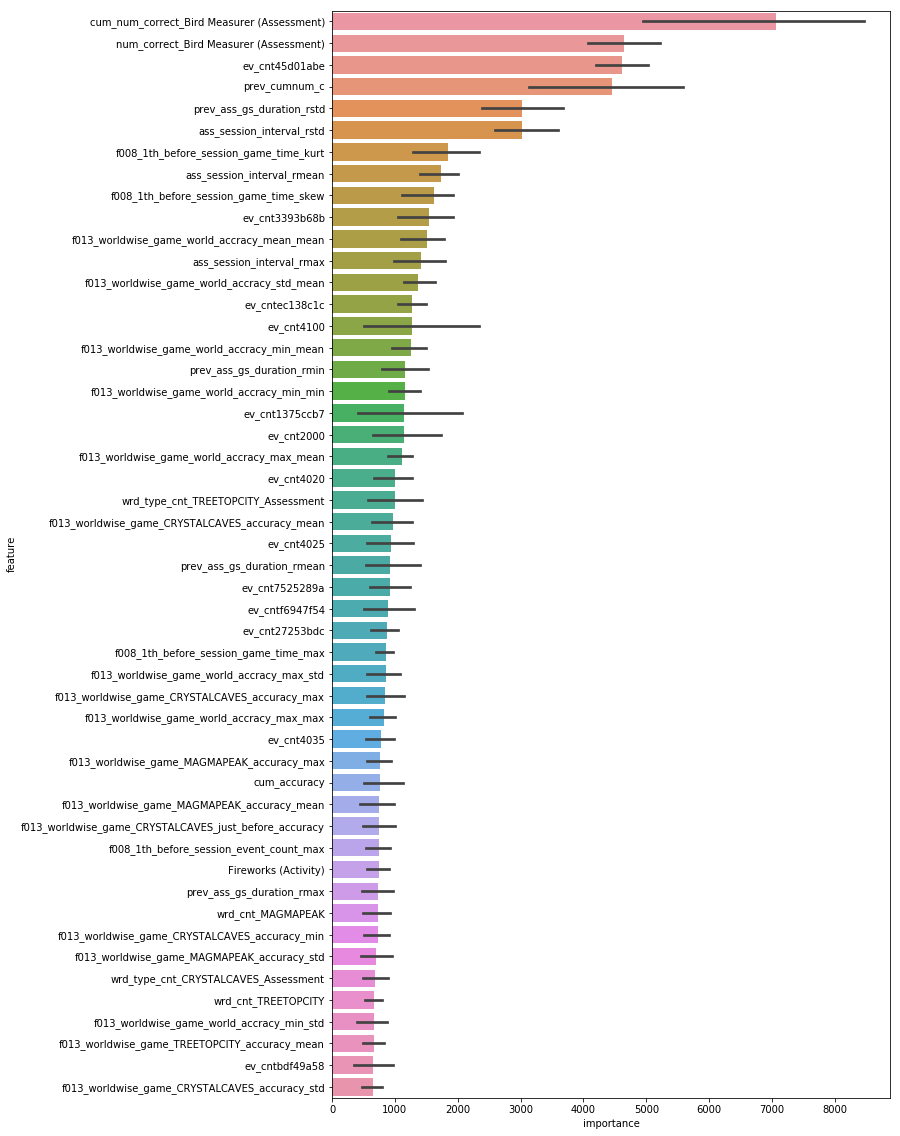

In [198]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().feature.head(50))

#### oof 見てみる

In [45]:
ls ../mnt/oofs/e025/

e025_oof.pkl


In [132]:
import pickle
with open ('../mnt/oofs/e025/e025_oof.pkl', 'rb') as fin:
    oof = pickle.load(fin)

In [133]:
oof.shape

(18690,)

In [134]:
label_df.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [135]:
label_df['installation_id'].values

array(['0006a69f', '0006a69f', '0006a69f', ..., 'ffeb0b1b', 'ffeb0b1b',
       'ffeb0b1b'], dtype=object)

In [180]:
oof_df = pd.DataFrame(oof)
oof_df.columns = ['y_pred']
oof_df.loc[:label_df.shape[0]-1, 'is_train'] = 1
oof_df.loc[label_df.shape[0]:, 'is_train'] = 0

oof_df['installation_id'] = None
oof_df['game_session'] = None
oof_df.loc[:label_df.shape[0]-1, ['installation_id', 'game_session']] = label_df[['installation_id', 'game_session']].values
oof_df.loc[label_df.shape[0]:, 'installation_id'] = sub_df['installation_id'].values
oof_df.loc[label_df.shape[0]:, 'game_session'] = 'temp'

oof_df.head()

,y_pred,is_train,installation_id,game_session
0,0.929424,1.0,0006a69f,6bdf9623adc94d89
1,0.953814,1.0,0006a69f,77b8ee947eb84b4e
2,0.950770,1.0,0006a69f,901acc108f55a5a1
3,0.954759,1.0,0006a69f,9501794defd84e4d
4,0.963089,1.0,0006a69f,a9ef3ecb3d1acc6a


In [181]:
trn_kernel_basics_df = pd.read_pickle(f'{TRN_BASE_DIR}/KernelBasics3.pkl')
tst_kernel_basics_df = pd.read_pickle(f'{TST_BASE_DIR}/KernelBasics3.pkl')
tst_kernel_basics_df['game_session'] = 'temp'

In [182]:
trn_prev_assess_acc_by_titile_df = pd.read_pickle(f'{TRN_BASE_DIR}/PrevAssessAccByTitle.pkl')
tst_prev_assess_acc_by_titile_df = pd.read_pickle(f'{TST_BASE_DIR}/PrevAssessAccByTitle.pkl')
tst_prev_assess_acc_by_titile_df['game_session'] = 'temp'

In [182]:
trn_prev_assess_acc_by_titile_df = pd.read_pickle(f'{TRN_BASE_DIR}/PrevAssessAccByTitle.pkl')
tst_prev_assess_acc_by_titile_df = pd.read_pickle(f'{TST_BASE_DIR}/PrevAssessAccByTitle.pkl')
tst_prev_assess_acc_by_titile_df['game_session'] = 'temp'

In [183]:
kernel_basics_df = pd.concat([trn_kernel_basics_df, tst_kernel_basics_df], axis=0)
oof_df = oof_df.merge(kernel_basics_df, on=['installation_id', 'game_session'], how='left')

prev_assess_acc_by_titile_df = pd.concat([trn_prev_assess_acc_by_titile_df, tst_prev_assess_acc_by_titile_df], axis=0)
oof_df = oof_df.merge(prev_assess_acc_by_titile_df, on=['installation_id', 'game_session'], how='left')

oof_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,y_pred,is_train,installation_id,game_session,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),...,num_correct_Bird Measurer (Assessment),num_correct_Cart Balancer (Assessment),num_correct_Cauldron Filler (Assessment),num_correct_Chest Sorter (Assessment),num_correct_Mushroom Sorter (Assessment),num_incorrect_Bird Measurer (Assessment),num_incorrect_Cart Balancer (Assessment),num_incorrect_Cauldron Filler (Assessment),num_incorrect_Chest Sorter (Assessment),num_incorrect_Mushroom Sorter (Assessment)
0,0.929424,1.0,0006a69f,6bdf9623adc94d89,0.0,193134.0,164777.0,0.0,92799.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0
1,0.953814,1.0,0006a69f,77b8ee947eb84b4e,0.0,193134.0,164777.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.950770,1.0,0006a69f,901acc108f55a5a1,0.0,0.0,164777.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.954759,1.0,0006a69f,9501794defd84e4d,0.0,193134.0,231265.0,0.0,92799.0,165523.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.963089,1.0,0006a69f,a9ef3ecb3d1acc6a,0.0,337007.0,231265.0,0.0,92799.0,165523.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


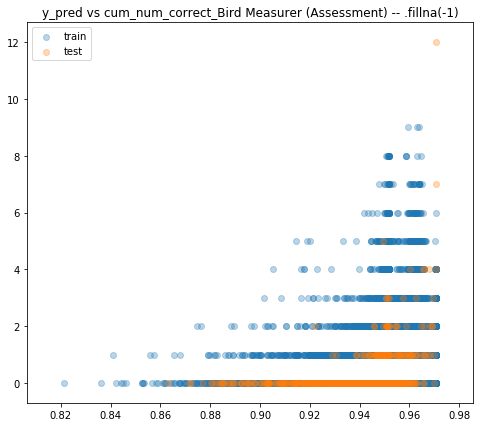

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
ax.scatter(oof_df.query('is_train == 1').y_pred, oof_df.query('is_train == 1')['cum_num_correct_Bird Measurer (Assessment)'].fillna(-1), alpha=0.3, label='train')
ax.scatter(oof_df.query('is_train == 0').y_pred, oof_df.query('is_train == 0')['cum_num_correct_Bird Measurer (Assessment)'].fillna(-1), alpha=0.3, label='test')

ax.set_title('y_pred vs cum_num_correct_Bird Measurer (Assessment) -- .fillna(-1)')
ax.legend()
plt.show()

In [170]:
imp_df.groupby('feature').mean().reset_index().sort_values('importance', ascending=False)

,feature,importance,fold
535,prev_ass_gs_duration_rstd,1969.021567,2
536,prev_cumnum_c,1933.386187,2
54,ass_session_interval_rstd,1765.248394,2
53,ass_session_interval_rmean,851.826892,2
201,ev_cnt4100,713.538233,2
...,...,...,...
322,ev_cnt8ac7cce4,0.000000,2
338,ev_cnt93edfe2e,0.000000,2
339,ev_cnt9554a50b,0.000000,2
340,ev_cnt99abe2bb,0.000000,2


KeyError: 'prev_ass_gs_duration_rstd'

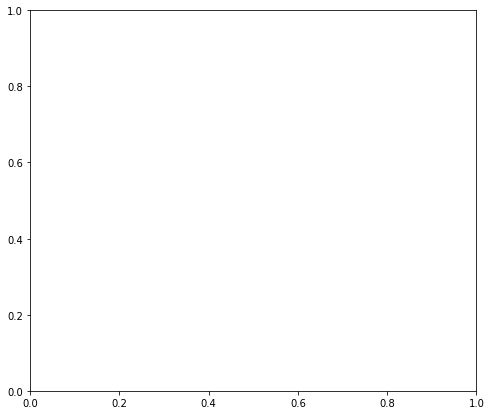

In [185]:
FEATURE = 'prev_ass_gs_duration_rstd'

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
ax.scatter(oof_df.query('is_train == 1').y_pred, oof_df.query('is_train == 1')[f'{FEATURE}'].fillna(-1), alpha=0.3, label='train')
ax.scatter(oof_df.query('is_train == 0').y_pred, oof_df.query('is_train == 0')[f'{FEATURE}'].fillna(-1), alpha=0.3, label='test')

ax.set_title(f'{FEATURE} -- .fillna(-1)')
ax.legend()
plt.show()

In [100]:
from sklearn.metrics import roc_auc_score
roc_auc_score(oof_df['is_train'], oof_df['y_pred'])

0.747749886941775

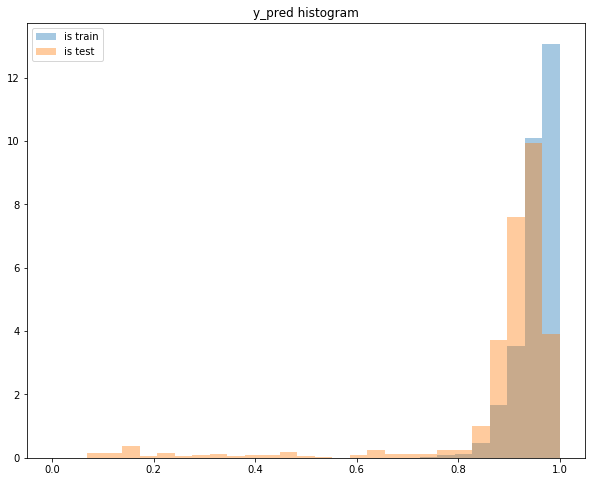

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.hist(oof_df.query('is_train == 1').y_pred, bins=np.linspace(0, 1, 30), alpha=0.4, label='is train', normed=True)
ax.hist(oof_df.query('is_train == 0').y_pred, bins=np.linspace(0, 1, 30), alpha=0.4, label='is test', normed=True)
ax.set_title('y_pred histogram')
ax.legend()

plt.show()

In [14]:
imp_df =  pd.read_csv('../mnt/importances/e023.csv')

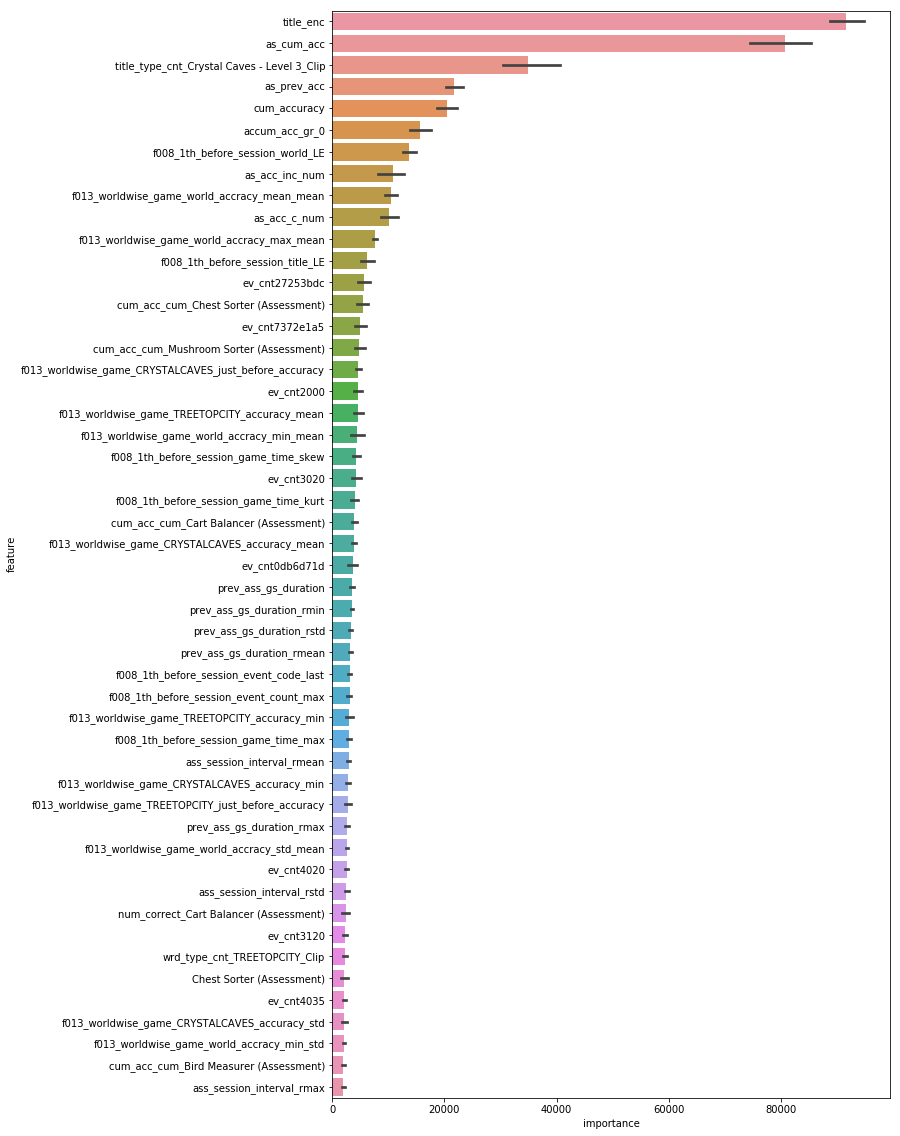

In [15]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().feature.head(50))

In [17]:
imp_df[imp_df.feature.str.contains('prev_acc_gr_')]

,feature,importance,fold
48,prev_acc_gr_0,698.300962,0
49,prev_acc_gr_1,21.164470,0
50,prev_acc_gr_2,37.376540,0
51,prev_acc_gr_3,134.101332,0
645,prev_acc_gr_0,611.472326,1
646,prev_acc_gr_1,46.338379,1
647,prev_acc_gr_2,45.687390,1
648,prev_acc_gr_3,171.692971,1
1242,prev_acc_gr_0,494.605092,2
1243,prev_acc_gr_1,44.760450,2


In [18]:
imp_df[imp_df.feature.str.contains('accum_acc_gr_')]

,feature,importance,fold
44,accum_acc_gr_0,12224.327171,0
45,accum_acc_gr_1,100.891551,0
46,accum_acc_gr_2,73.611501,0
641,accum_acc_gr_0,16633.221862,1
642,accum_acc_gr_1,226.841221,1
643,accum_acc_gr_2,180.523549,1
1238,accum_acc_gr_0,17134.152410,2
1239,accum_acc_gr_1,88.355980,2
1240,accum_acc_gr_2,127.356200,2
1835,accum_acc_gr_0,14115.289149,3


In [200]:
imp_df =  pd.read_csv('../mnt/importances/e026.csv')

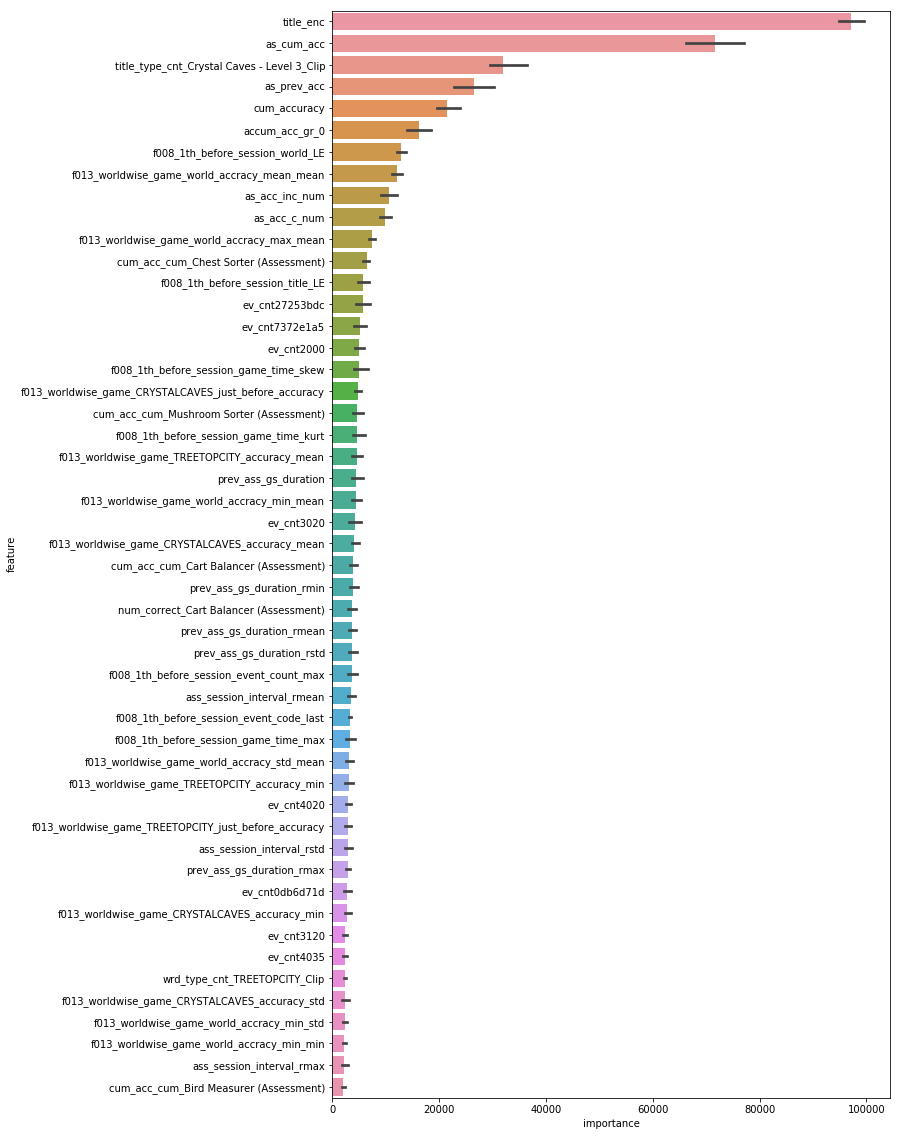

In [201]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.groupby('feature').importance.mean().sort_values(ascending=False).reset_index().feature.head(50))